# 2A. Data Preprocessing

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


# Handling Missing Values

In [6]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100

# Display the missing values
missing_values, missing_values_percentage


(gender                 0
 age                    0
 hypertension           0
 heart_disease          0
 smoking_history        0
 bmi                    0
 HbA1c_level            0
 blood_glucose_level    0
 diabetes               0
 dtype: int64,
 gender                 0.0
 age                    0.0
 hypertension           0.0
 heart_disease          0.0
 smoking_history        0.0
 bmi                    0.0
 HbA1c_level            0.0
 blood_glucose_level    0.0
 diabetes               0.0
 dtype: float64)

# Handling Outliers

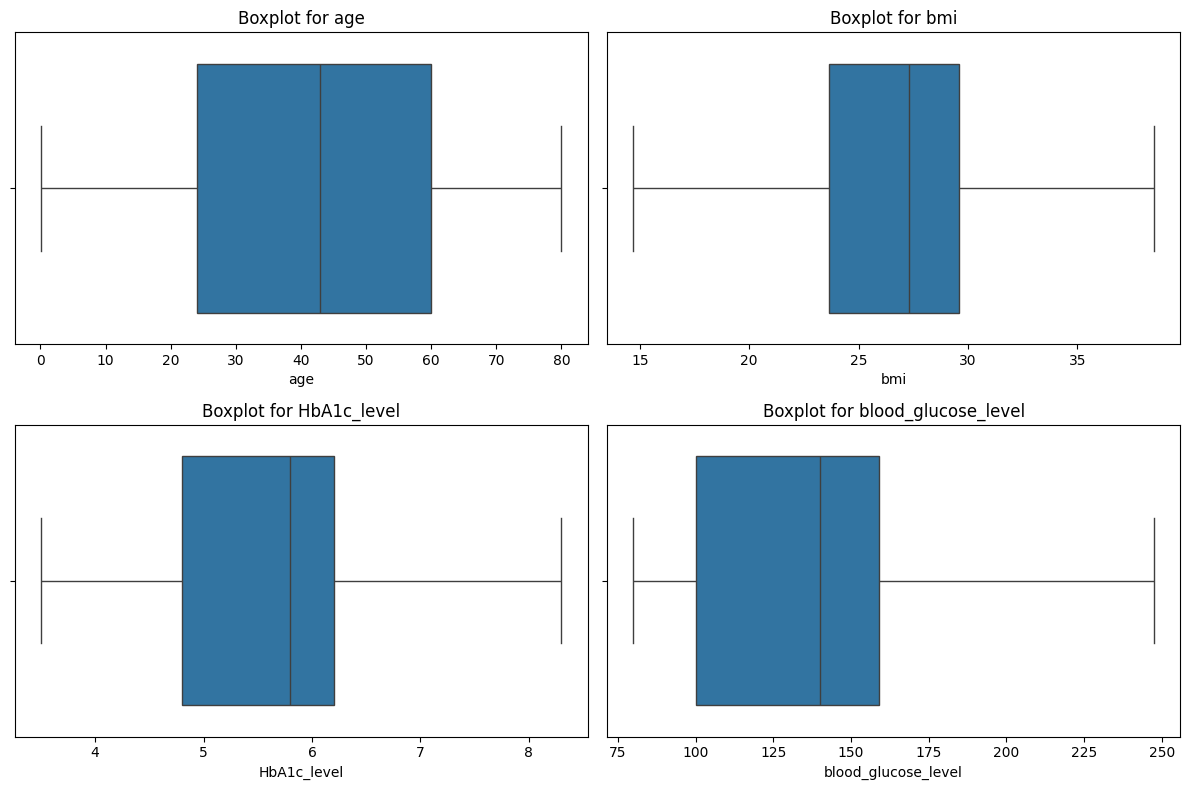

age                    0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
dtype: int64

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
numerical_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Create boxplots to visualize outliers in numerical columns
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot for {column}')
plt.tight_layout()
plt.show()

# Calculate IQR and identify potential outliers
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as data points outside the 1.5 * IQR range
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))

# Check outliers
outliers_summary = outliers.sum()
outliers_summary

# Capping outliers based on IQR
for column in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
    df[column] = df[column].clip(lower=Q1[column] - 1.5 * IQR[column], upper=Q3[column] + 1.5 * IQR[column])

# Verify if the outliers have been capped
outliers_after_capping = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).sum()
outliers_after_capping


# Binning 

In [8]:
# Define age bins and labels
age_bins = [0, 18, 35, 50, 65, 100]
age_labels = ['Under 18', '18-35', '36-50', '51-65', '66+']

# Create a new column 'age_group' based on the bins
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Display the new age group column
df['age_group'].value_counts()

age_group
18-35       21541
51-65       21350
36-50       21322
66+         18568
Under 18    17219
Name: count, dtype: int64

# Encoding

In [9]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to 'gender'
df['gender'] = label_encoder.fit_transform(df['gender'])
df['smoking_history'] = label_encoder.fit_transform(df['smoking_history'])
df['age_group'] = label_encoder.fit_transform(df['age_group'])

# Display the encoded data
df.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group
0,0,80.0,0,1,4,25.19,6.6,140.0,0,3
1,0,54.0,0,0,0,27.32,6.6,80.0,0,2
2,1,28.0,0,0,4,27.32,5.7,158.0,0,0
3,0,36.0,0,0,1,23.45,5.0,155.0,0,1
4,1,76.0,1,1,1,20.14,4.8,155.0,0,3


# Grouping

In [10]:
# Group by 'diabetes' and calculate summary statistics
grouped_df = df.groupby('diabetes').agg({
    'age': ['mean', 'std'],
    'bmi': ['mean', 'std'],
    'HbA1c_level': ['mean', 'std'],
    'blood_glucose_level': ['mean', 'std'],
    'hypertension': 'mean',
    'heart_disease': 'mean'
})

# Display the grouped statistics
grouped_df


age                   bmi           HbA1c_level            \
               mean        std       mean       std        mean       std   
diabetes                                                                    
0         40.115187  22.306005  26.629279  5.566786    5.396761  0.971628   
1         60.946588  14.549880  30.892889  5.309827    6.842212  0.916522   

         blood_glucose_level            hypertension heart_disease  
                        mean        std         mean          mean  
diabetes                                                            
0                 132.852470  34.247281     0.058984      0.029235  
1                 186.210588  47.048412     0.245647      0.149059

# 2B. Data Visualization

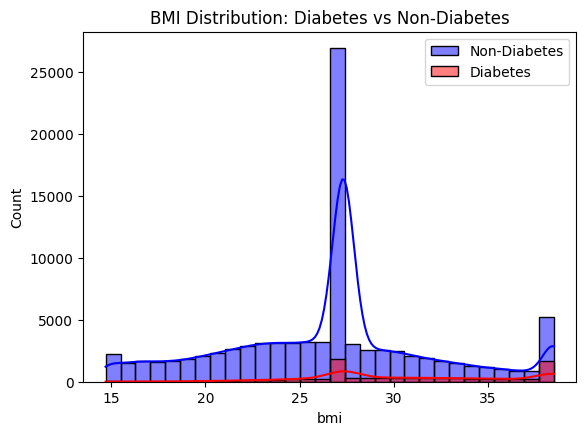

In [11]:
# Visualize the distribution of key features: BMI, Age, HbA1c, etc.
plt.figure(figsize=(14, 10))

# Histogram for BMI
plt.subplot(2, 2, 1)
sns.histplot(df[df['diabetes'] == 0]['bmi'], kde=True, color='blue', label='Non-Diabetes', bins=30)
sns.histplot(df[df['diabetes'] == 1]['bmi'], kde=True, color='red', label='Diabetes', bins=30)
plt.legend()
plt.title('BMI Distribution: Diabetes vs Non-Diabetes')
plt.show()

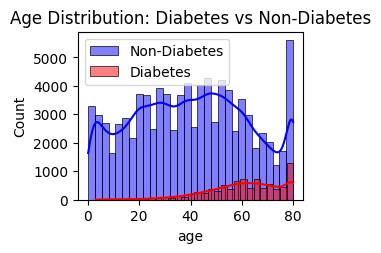

In [12]:
# Histogram for Age
plt.subplot(2, 2, 2)
sns.histplot(df[df['diabetes'] == 0]['age'], kde=True, color='blue', label='Non-Diabetes', bins=30)
sns.histplot(df[df['diabetes'] == 1]['age'], kde=True, color='red', label='Diabetes', bins=30)
plt.legend()
plt.title('Age Distribution: Diabetes vs Non-Diabetes')
plt.show()

Text(0.5, 1.0, 'HbA1c Level Distribution: Diabetes vs Non-Diabetes')

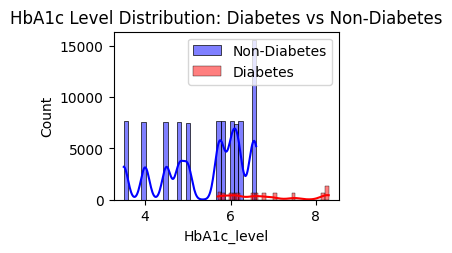

In [13]:
# Histogram for HbA1c Level
plt.subplot(2, 2, 3)
sns.histplot(df[df['diabetes'] == 0]['HbA1c_level'], kde=True, color='blue', label='Non-Diabetes', bins=30)
sns.histplot(df[df['diabetes'] == 1]['HbA1c_level'], kde=True, color='red', label='Diabetes', bins=30)
plt.legend()
plt.title('HbA1c Level Distribution: Diabetes vs Non-Diabetes')

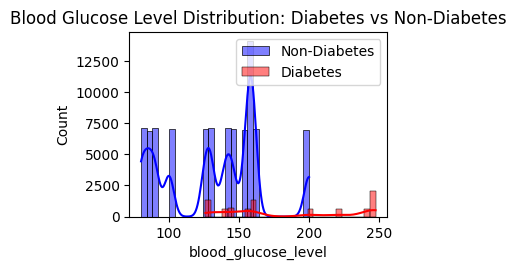

In [14]:
# Histogram for Blood Glucose Level
plt.subplot(2, 2, 4)
sns.histplot(df[df['diabetes'] == 0]['blood_glucose_level'], kde=True, color='blue', label='Non-Diabetes', bins=30)
sns.histplot(df[df['diabetes'] == 1]['blood_glucose_level'], kde=True, color='red', label='Diabetes', bins=30)
plt.legend()
plt.title('Blood Glucose Level Distribution: Diabetes vs Non-Diabetes')

plt.tight_layout()
plt.show()

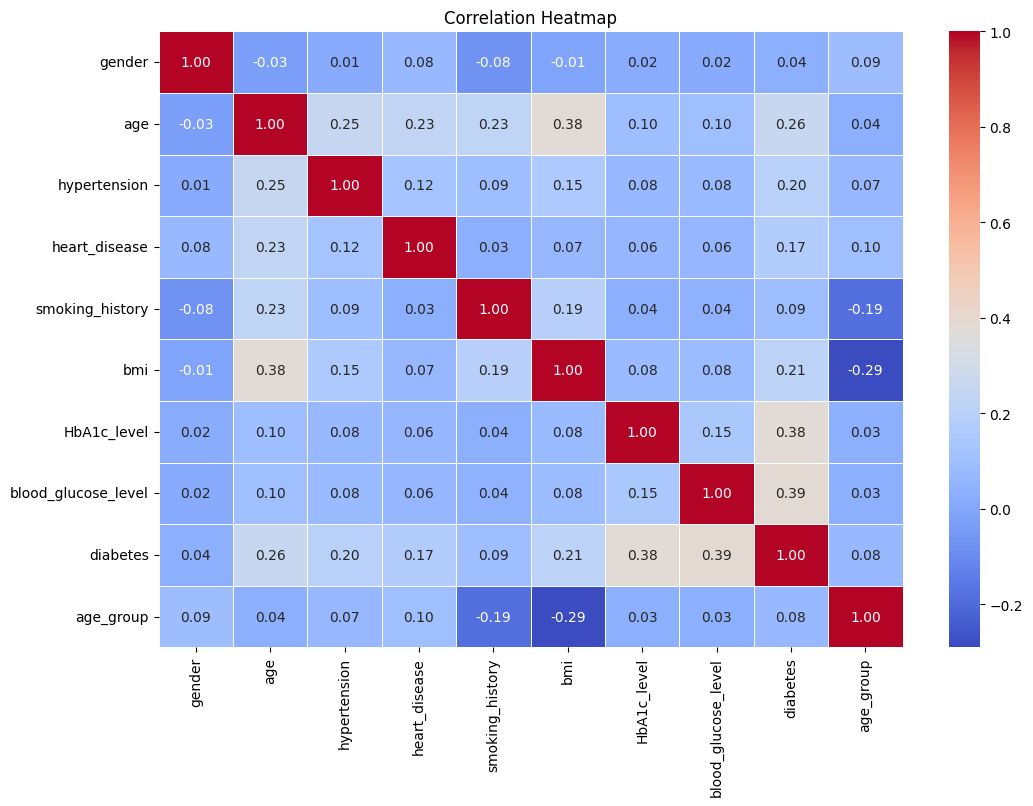

In [15]:
# Correlation Heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## DECISION TREE RANDOM FOREST

In [16]:


# Define the features (X) and target (y)
X = df.drop(columns=['diabetes', 'age_group'])  # Exclude target and 'age_group'
y = df['diabetes']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)

# Train the model
model_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = model_dt.predict(X_test)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred_dt)
confusion_mat = confusion_matrix(y_test, y_pred_dt)

# Display the results
print("Classification Report:")
print(classification_rep)

print("\nConfusion Matrix:")
print(confusion_mat)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18292
           1       0.71      0.73      0.72      1708

    accuracy                           0.95     20000
   macro avg       0.84      0.85      0.85     20000
weighted avg       0.95      0.95      0.95     20000


Confusion Matrix:
[[17790   502]
 [  455  1253]]


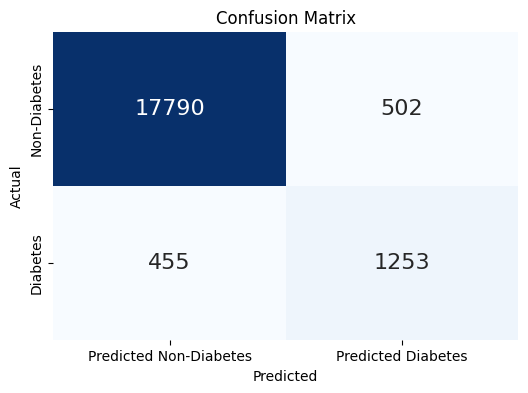

In [17]:
# Convert confusion matrix to DataFrame for better readability
conf_matrix_df = pd.DataFrame(confusion_mat, index=['Non-Diabetes', 'Diabetes'], columns=['Predicted Non-Diabetes', 'Predicted Diabetes'])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## EVALUATION FOR XGB

C:\Users\ACER\Downloads\Datnal\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:47:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.96      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
[[18245    47]
 [  530  1178]]


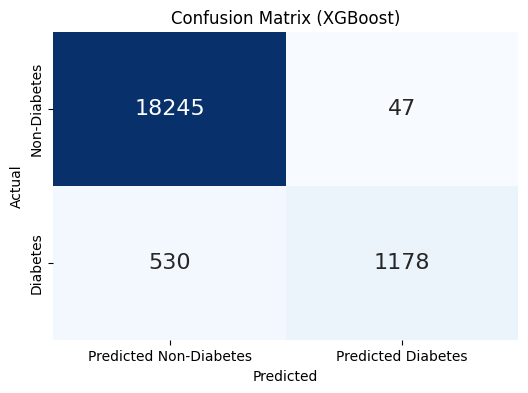

In [18]:

# Define the features (X) and target (y) A
X = df.drop(columns=['diabetes', 'age_group'])  # Exclude target and 'age_group'
y = df['diabetes']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model B
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
model_xgb.fit(X_train, y_train)

# Make predictions C
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model EVALUATION MODEL
classification_rep = classification_report(y_test, y_pred_xgb)
confusion_mat = confusion_matrix(y_test, y_pred_xgb)

# Display the results
print("Classification Report:")
print(classification_rep)

print("\nConfusion Matrix:")
print(confusion_mat)

# Visualizing the Confusion Matrix
conf_matrix_df = pd.DataFrame(confusion_mat, index=['Non-Diabetes', 'Diabetes'], columns=['Predicted Non-Diabetes', 'Predicted Diabetes'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix (XGBoost)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## EVALUATION FOR DECISION TREE

In [19]:

# Tentukan fitur (X) dan target (y)
X = df.drop(columns=['diabetes', 'age_group'])  # Kecualikan target dan 'age_group'
y = df['diabetes']

# Membagi data menjadi training dan testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Melatih Model Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Prediksi dengan Decision Tree
y_pred_dt = model_dt.predict(X_test)

# Menghitung akurasi Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Akurasi Decision Tree: {accuracy_dt:.4f}')

# 2. Melatih Model XGBoost
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# Prediksi dengan XGBoost
y_pred_xgb = model_xgb.predict(X_test)

# Menghitung akurasi XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Akurasi XGBoost: {accuracy_xgb:.4f}')

# 3. Perbandingan Akurasi
if accuracy_dt > accuracy_xgb:
    print(f"\nDecision Tree lebih baik dengan akurasi  {accuracy_dt:.4f}")
else:
    print(f"\nXGBoost lebih baik dengan akurasi  {accuracy_xgb:.4f}")


Akurasi Decision Tree: 0.9522


C:\Users\ACER\Downloads\Datnal\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:47:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Akurasi XGBoost: 0.9711

XGBoost lebih baik dengan akurasi  0.9711


In [20]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group
0,0,80.0,0,1,4,25.19,6.6,140.0,0,3
1,0,54.0,0,0,0,27.32,6.6,80.0,0,2
2,1,28.0,0,0,4,27.32,5.7,158.0,0,0
3,0,36.0,0,0,1,23.45,5.0,155.0,0,1
4,1,76.0,1,1,1,20.14,4.8,155.0,0,3


In [21]:
import joblib

joblib.dump(model_xgb, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [22]:
import joblib

joblib.dump(model_dt, 'dt_model.pkl')

['dt_model.pkl']

In [23]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [24]:
import streamlit as st

In [25]:
# Memuat model yang telah disimpan
model_xgb = joblib.load('xgboost_model.pkl')

# Fungsi untuk prediksi
def predict_diabetes(age, hypertension, heart_disease, smoking_history, bmi, hba1c, glucose):
    input_data = np.array([[age, hypertension, heart_disease, smoking_history, bmi, hba1c, glucose]]).astype(float)
    prediction = model_xgb.predict(input_data)
    return prediction[0]

# Streamlit interface
st.title('Prediksi Diabetes dengan XGBoost')

# Input data
age = st.number_input('Usia', min_value=0, max_value=100, value=25)
hypertension = st.selectbox('Apakah Anda hipertensi?', ['Tidak', 'Ya'])
heart_disease = st.selectbox('Apakah Anda menderita penyakit jantung?', ['Tidak', 'Ya'])
smoking_history = st.selectbox('Riwayat merokok', ['Tidak', 'Pernah', 'Saat ini'])
bmi = st.number_input('BMI', min_value=10, max_value=50, value=25)
hba1c = st.number_input('Level HbA1c', min_value=4, max_value=10, value=6)
glucose = st.number_input('Level Glukosa Darah', min_value=50, max_value=300, value=100)

# Mengonversi input ke dalam bentuk numerik
hypertension = 1 if hypertension == 'Ya' else 0
heart_disease = 1 if heart_disease == 'Ya' else 0
smoking_history = 1 if smoking_history == 'Saat ini' else (0 if smoking_history == 'Tidak' else 2)  # 2 = 'Pernah'

# Tombol prediksi
if st.button('Prediksi Diabetes'):
    result = predict_diabetes(age, hypertension, heart_disease, smoking_history, bmi, hba1c, glucose)
    if result == 1:
        st.success('Anda berisiko diabetes')
    else:
        st.success('Anda tidak berisiko diabetes')


2025-12-08 18:47:18.445 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 18:47:20.031 
  command:

    streamlit run C:\Users\ACER\Downloads\Datnal\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-08 18:47:20.033 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 18:47:20.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 18:47:20.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 18:47:20.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 18:47:20.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-08 18:47:20.043 Thread 'MainThrea

## UAS 

## DECISION TREE RANDOMIZED SEARCH

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

# Parameter yang ingin dicoba
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None],
}

dt_model = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV
randomized_search = RandomizedSearchCV(estimator=dt_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
randomized_search.fit(X_train, y_train)

print("Best Parameters:", randomized_search.best_params_)
print("Best Accuracy:", randomized_search.best_score_)

C:\Users\ACER\Downloads\Datnal\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
130 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
44 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ACER\Downloads\Datnal\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ACER\Downloads\Datnal\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\ACER\Downloads\Datnal\Lib\site-packages\sklearn\base.py", line 471

Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 9}
Best Accuracy: 0.9718


## HASIL AKURASI AWAL DECISION TREE : 95.22
## HASIL AKURASI AKHIR OPTIMIZE DECISION TREE : 97.18

## Saya Optimize Decision Tree karena menurut saya untuk XGB Boost sudah sangat bagus dan Sudah menyentuh Kapasitas Maksimal dari datasetnya sehinnga saya memilih untuk memaksimalkan Decision Tree